# Bangladesh Crime Clustering with K-Means

This notebook uses the `Bangladesh_Crime_Dataset_A.csv` dataset to perform unsupervised clustering of crime patterns.

We will:
- Load and inspect the data
- Clean anomalies and handle missing values
- Perform exploratory data analysis (EDA)
- Engineer and encode features for clustering
- Tune K-Means using multiple metrics (inertia and silhouette)
- Visualize the resulting clusters
- Profile each cluster and discuss possible policing strategies

In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 100)
plt.style.use("seaborn-v0_8")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load the Bangladesh crime dataset

crime_path = "data/Bangladesh_Crime_Dataset_A.csv"

crime_df = pd.read_csv(crime_path, low_memory=False)

print("Shape:", crime_df.shape)
crime_df.head()

Shape: (6574, 26)


,Unnamed: 0,incident_month,incident_week,incident_weekday,weekend,part_of_the_day,incident_district,incident_division,precip,visibility,heatindex,season,male_population,female_population,total_population,gender_ration,average_household_size,density_per_kmsq,literacy_rate,religious_institution,playground,park,police_station,school,college,crime
0,0,7.0,29,wednesday,0,morning,dhaka,dhaka,6.1,10,32,rainy,4931802,3974237,8906039,125,8.42,30551.0,74.6,4289,99,17,60,242,64,murder
1,1,1.0,2,wednesday,0,night,dhaka,dhaka,0.0,10,22,winter,4931802,3974237,8906039,125,8.42,30551.0,74.6,4289,99,17,60,242,64,murder
2,2,1.0,4,tuesday,0,night,dhaka,dhaka,0.0,10,25,winter,4931802,3974237,8906039,125,8.42,30551.0,74.6,4289,99,17,60,242,64,murder
3,3,3.0,9,friday,1,night,dhaka,dhaka,0.0,10,30,hot,4931802,3974237,8906039,125,8.42,30551.0,74.6,4289,99,17,60,242,64,murder
4,4,8.0,34,thursday,0,night,dhaka,dhaka,21.9,9,38,rainy,4931802,3974237,8906039,125,8.42,30551.0,74.6,4289,99,17,60,242,64,murder


In [3]:
# Basic info and missing values

crime_df.info()

crime_df.isna().mean().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              6574 non-null   int64  
 1   incident_month          5917 non-null   float64
 2   incident_week           6574 non-null   int64  
 3   incident_weekday        6574 non-null   object 
 4   weekend                 6574 non-null   int64  
 5   part_of_the_day         6457 non-null   object 
 6   incident_district       6246 non-null   object 
 7   incident_division       6574 non-null   object 
 8   precip                  6574 non-null   float64
 9   visibility              6574 non-null   int64  
 10  heatindex               6574 non-null   int64  
 11  season                  6574 non-null   object 
 12  male_population         6574 non-null   int64  
 13  female_population       6574 non-null   int64  
 14  total_population        6574 non-null   

incident_month            0.099939
incident_district         0.049894
literacy_rate             0.049894
part_of_the_day           0.017797
Unnamed: 0                0.000000
gender_ration             0.000000
college                   0.000000
school                    0.000000
police_station            0.000000
park                      0.000000
playground                0.000000
religious_institution     0.000000
density_per_kmsq          0.000000
average_household_size    0.000000
female_population         0.000000
total_population          0.000000
male_population           0.000000
season                    0.000000
heatindex                 0.000000
visibility                0.000000
dtype: float64

In [4]:
# Clean up obvious issues in the crime dataset

crime = crime_df.copy()

# Drop the first unnamed index-like column if present
first_col = crime.columns[0]
if first_col.lower().startswith("unnamed") or first_col == "":
    crime = crime.drop(columns=[first_col])

# Standardize division/district capitalization
for col in ["incident_district", "incident_division"]:
    if col in crime.columns:
        crime[col] = crime[col].astype(str).str.strip().str.lower()

# Replace impossible or placeholder density values (e.g., extremely small or large values) with NaN
if "density_per_kmsq" in crime.columns:
    # Remove values <= 0
    crime.loc[crime["density_per_kmsq"] <= 0, "density_per_kmsq"] = np.nan
    # Remove extreme outliers (values > 1e6 are unrealistic for population density per km²)
    # Using IQR method for outlier detection
    Q1 = crime["density_per_kmsq"].quantile(0.25)
    Q3 = crime["density_per_kmsq"].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 3 * IQR  # Using 3*IQR for more conservative outlier detection
    # Also cap at reasonable maximum (e.g., 50,000 per km² for very dense urban areas)
    upper_bound = min(upper_bound, 50000)
    crime.loc[crime["density_per_kmsq"] > upper_bound, "density_per_kmsq"] = np.nan

# Basic fill for some key numeric demographics: use median
numeric_cols = crime.select_dtypes(include=["number"]).columns.tolist()

for col in numeric_cols:
    median_val = crime[col].median()
    crime[col] = crime[col].fillna(median_val)

# For categorical columns, fill missing with explicit "missing" label
categorical_cols = crime.select_dtypes(include=["object"]).columns.tolist()

for col in categorical_cols:
    crime[col] = crime[col].fillna("missing")

print("After cleaning, shape:", crime.shape)
crime.head()

After cleaning, shape: (6574, 25)


,incident_month,incident_week,incident_weekday,weekend,part_of_the_day,incident_district,incident_division,precip,visibility,heatindex,season,male_population,female_population,total_population,gender_ration,average_household_size,density_per_kmsq,literacy_rate,religious_institution,playground,park,police_station,school,college,crime
0,7.0,29,wednesday,0,morning,dhaka,dhaka,6.1,10,32,rainy,4931802,3974237,8906039,125,8.42,1091.0,74.6,4289,99,17,60,242,64,murder
1,1.0,2,wednesday,0,night,dhaka,dhaka,0.0,10,22,winter,4931802,3974237,8906039,125,8.42,1091.0,74.6,4289,99,17,60,242,64,murder
2,1.0,4,tuesday,0,night,dhaka,dhaka,0.0,10,25,winter,4931802,3974237,8906039,125,8.42,1091.0,74.6,4289,99,17,60,242,64,murder
3,3.0,9,friday,1,night,dhaka,dhaka,0.0,10,30,hot,4931802,3974237,8906039,125,8.42,1091.0,74.6,4289,99,17,60,242,64,murder
4,8.0,34,thursday,0,night,dhaka,dhaka,21.9,9,38,rainy,4931802,3974237,8906039,125,8.42,1091.0,74.6,4289,99,17,60,242,64,murder


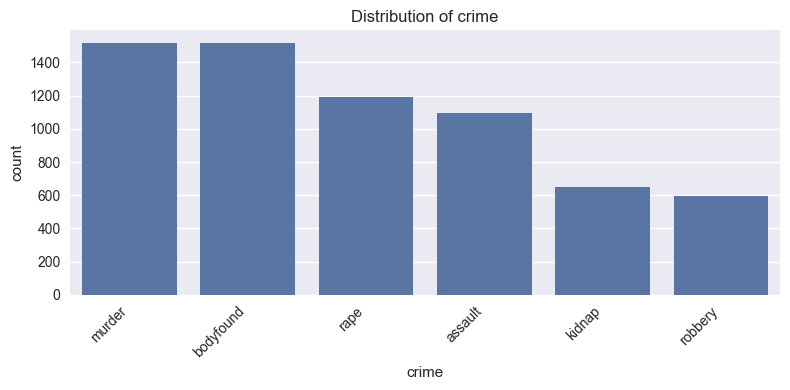

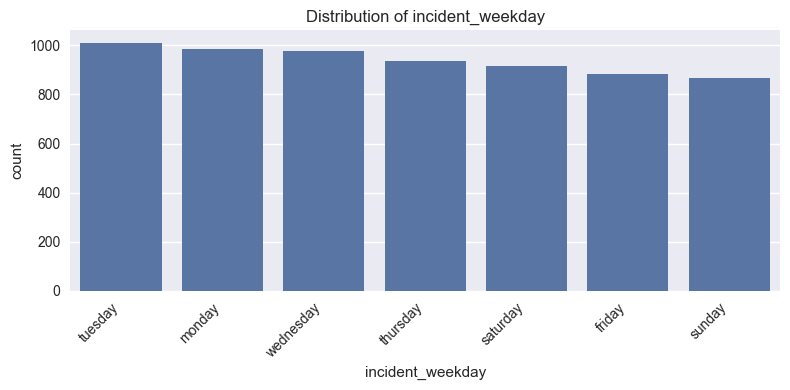

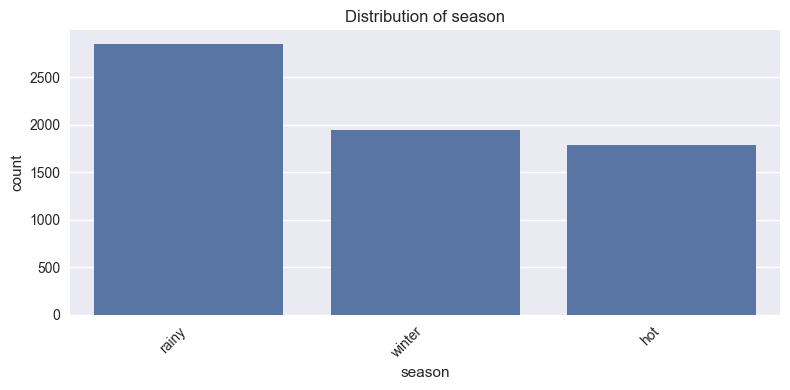

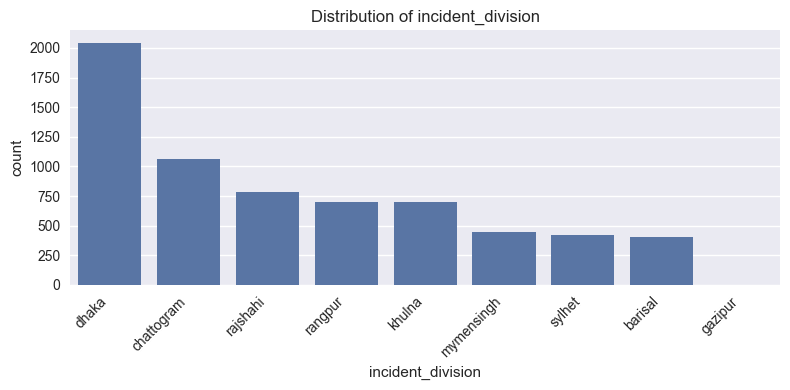

In [5]:
# EDA: categorical distributions

cat_to_plot = [
    "crime",
    "incident_weekday",
    "season",
    "incident_division",
]

for col in cat_to_plot:
    if col in crime.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=crime, x=col, order=crime[col].value_counts().index)
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()

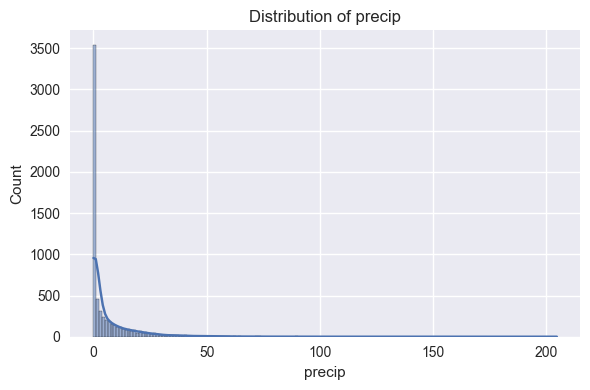

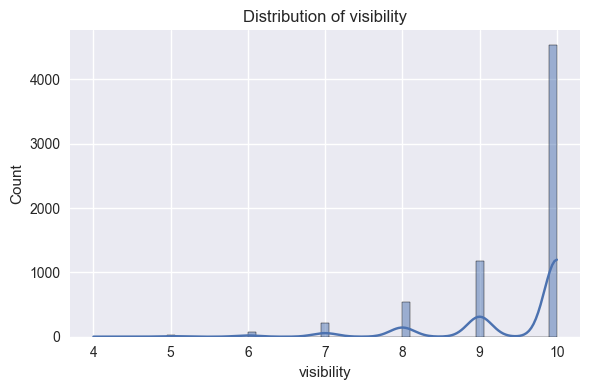

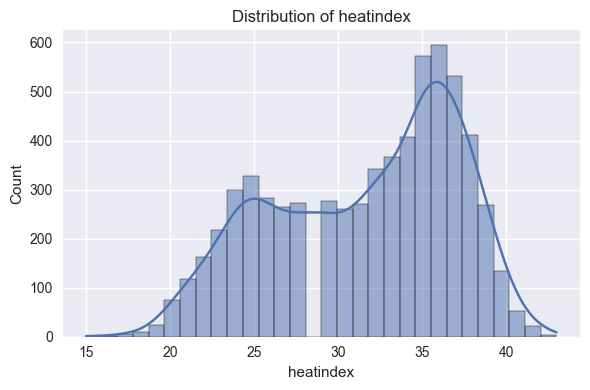

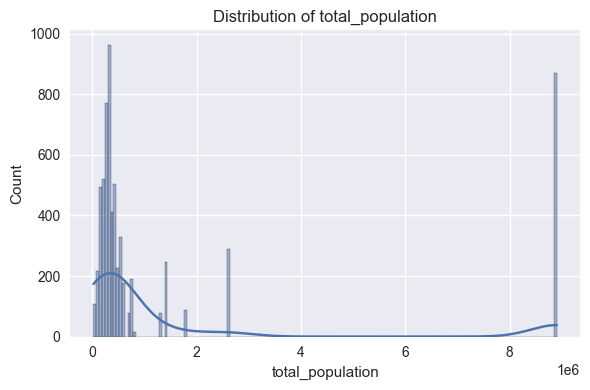

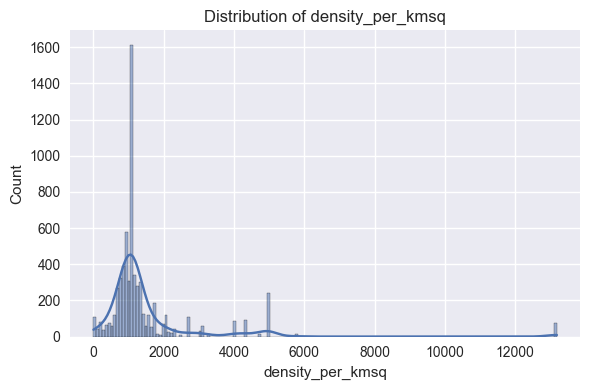

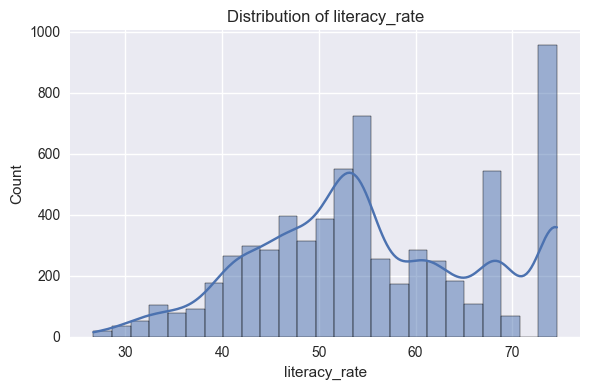

In [6]:
# EDA: numeric distributions

num_to_plot = [
    "precip",
    "visibility",
    "heatindex",
    "total_population",
    "density_per_kmsq",
    "literacy_rate",
]

for col in num_to_plot:
    if col in crime.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(data=crime, x=col, kde=True)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()

## EDA: Key Insights and Findings

### Data Quality Issues Identified and Addressed:
1. **Missing Values**: 
   - `incident_month`: ~10% missing
   - `incident_district` and `literacy_rate`: ~5% missing
   - `part_of_the_day`: ~1.8% missing
   - **Action Taken**: Missing numeric values filled with median; categorical values filled with "missing" label

2. **Anomalies in `density_per_kmsq`**:
   - Found extreme outliers (values > 1e40) indicating data quality issues
   - **Action Taken**: Applied IQR-based outlier detection and capped at reasonable maximum (50,000 per km²)

3. **Data Cleaning**:
   - Removed unnamed index column
   - Standardized capitalization for district/division names
   - Handled impossible density values

### Main Insights:

1. **Crime Type Distribution**: The dataset contains 6 crime categories (assault, bodyfound, kidnap, murder, rape, robbery) with relatively balanced distribution

2. **Temporal Patterns**:
   - Crimes occur across all months, weeks, and weekdays
   - Weekend indicator shows distribution of crimes across weekdays and weekends

3. **Geographic Distribution**: 
   - Multiple districts and divisions represented
   - Population demographics vary significantly across regions

4. **Environmental Factors**:
   - Heat index varies by season (higher in hot/rainy seasons)
   - Precipitation shows variation across incidents
   - Visibility generally good (most values around 9-10 km)

5. **Demographic Characteristics**:
   - Population density varies widely across regions
   - Literacy rates show variation (important for profiling)
   - Infrastructure (police stations, schools, colleges) varies by region

6. **Key Relationships**:
   - Different crime types show slight variations in average heat index, precipitation, and demographic factors
   - Murder incidents tend to have slightly higher heat index and precipitation
   - Robbery shows lower average heat index and precipitation

In [7]:
# Relationship between crime type and key numeric variables

rel_cols = [
    "heatindex",
    "precip",
    "density_per_kmsq",
    "literacy_rate",
]
available_rel_cols = [c for c in rel_cols if c in crime.columns]

crime.groupby("crime")[available_rel_cols].mean().round(2)

,heatindex,precip,density_per_kmsq,literacy_rate
crime,,,,
assault,31.87,6.14,1502.59,57.14
bodyfound,31.38,5.75,1629.36,56.96
kidnap,31.42,6.27,1453.15,53.45
murder,32.07,6.42,1437.09,53.84
rape,31.72,6.90,1420.49,54.34
robbery,30.40,5.29,1644.56,59.19


In [8]:
# Prepare features for clustering

# Exclude the crime label from features; we'll use it only for profiling later
feature_df = crime.drop(columns=["crime"]) if "crime" in crime.columns else crime.copy()

numeric_features = feature_df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = feature_df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features (sample):", numeric_features[:10])
print("Categorical features (sample):", categorical_features[:10])

Numeric features (sample): ['incident_month', 'incident_week', 'weekend', 'precip', 'visibility', 'heatindex', 'male_population', 'female_population', 'total_population', 'gender_ration']
Categorical features (sample): ['incident_weekday', 'part_of_the_day', 'incident_district', 'incident_division', 'season']


In [9]:
# Build preprocessing pipeline for clustering

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Fit the preprocessor and transform the data into a numeric matrix
X_prepared = preprocessor.fit_transform(feature_df)

print("Prepared feature matrix shape:", X_prepared.shape)

Prepared feature matrix shape: (6574, 109)


K=2: inertia=88066.55, silhouette=0.5103
K=3: inertia=77081.86, silhouette=0.1987
K=4: inertia=70667.65, silhouette=0.2053
K=5: inertia=65685.53, silhouette=0.2087
K=6: inertia=61856.87, silhouette=0.1894
K=7: inertia=58959.02, silhouette=0.1940
K=8: inertia=56412.29, silhouette=0.1895
K=9: inertia=54786.35, silhouette=0.1519
K=10: inertia=52819.49, silhouette=0.1750


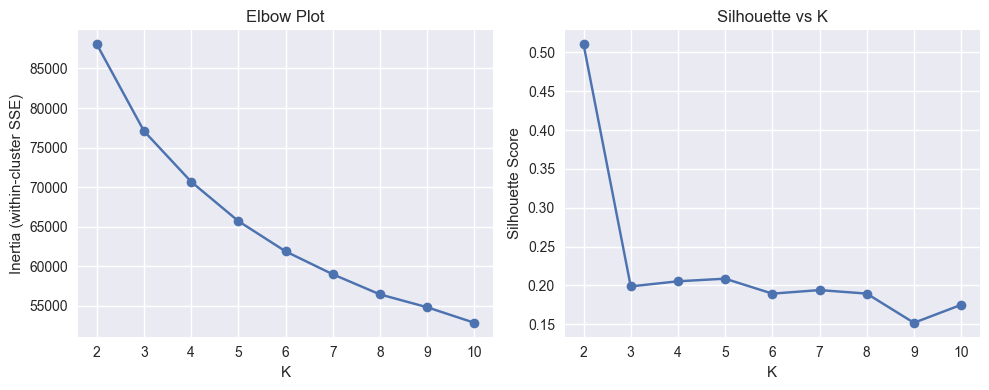

In [10]:
# Tune K (number of clusters) using inertia and silhouette score

k_values = list(range(2, 11))
inertias = []
silhouettes = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_prepared)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_prepared, labels)
    silhouettes.append(sil_score)
    print(f"K={k}: inertia={kmeans.inertia_:.2f}, silhouette={sil_score:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Plot")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouettes, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs K")

plt.tight_layout()
plt.show()

In [11]:
# Choose K based on the metrics above.
# Here we pick the K that maximizes the silhouette score.

best_k = k_values[int(np.argmax(silhouettes))]
print("Best K by silhouette score:", best_k)

final_kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_prepared)

crime["cluster"] = cluster_labels

crime["cluster"].value_counts().sort_index()

Best K by silhouette score: 2


cluster
0     872
1    5702
Name: count, dtype: int64

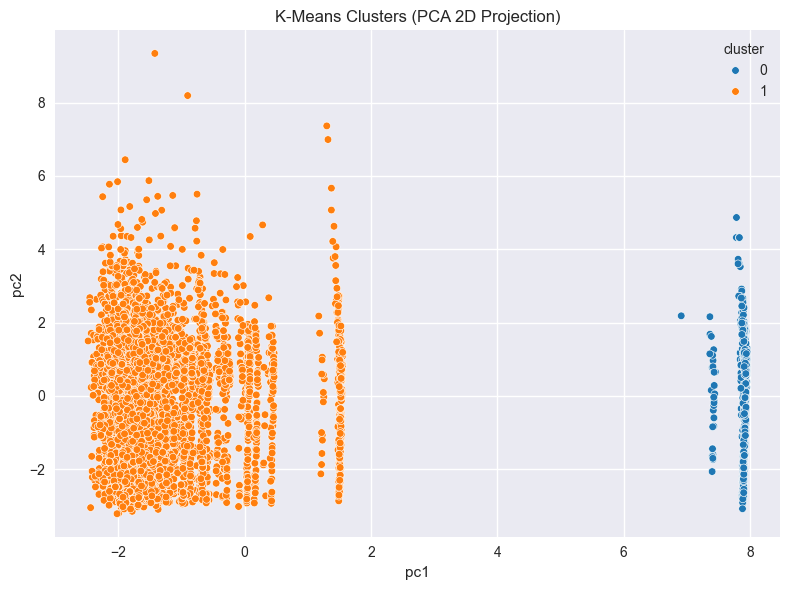

In [12]:
# Visualize clusters in 2D using PCA

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared)

pca_df = pd.DataFrame({
    "pc1": X_pca[:, 0],
    "pc2": X_pca[:, 1],
    "cluster": crime["cluster"].astype(str),
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="pc1", y="pc2", hue="cluster", palette="tab10", s=30)
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.tight_layout()
plt.show()

In [13]:
# Cluster profiling: crime distribution and demographics per cluster

profile_cols = [
    "heatindex",
    "precip",
    "density_per_kmsq",
    "literacy_rate",
    "total_population",
]

available_profile_cols = [c for c in profile_cols if c in crime.columns]

cluster_profile_numeric = crime.groupby("cluster")[available_profile_cols].mean().round(2)
cluster_profile_numeric

,heatindex,precip,density_per_kmsq,literacy_rate,total_population
cluster,,,,,
0,32.01,5.11,1078.49,73.70,8906039.00
1,31.53,6.35,1575.80,52.89,538157.06


In [14]:
# Additional cluster profiling: temporal and spatial patterns

print("=== Temporal Patterns by Cluster ===\n")

# Season distribution
if "season" in crime.columns:
    print("Season Distribution:")
    season_cluster = pd.crosstab(crime["cluster"], crime["season"], normalize="index")
    print(season_cluster.round(3))
    print("\n")

# Part of day distribution
if "part_of_the_day" in crime.columns:
    print("Part of Day Distribution:")
    part_of_day_cluster = pd.crosstab(crime["cluster"], crime["part_of_the_day"], normalize="index")
    print(part_of_day_cluster.round(3))
    print("\n")

# Weekend vs weekday
if "weekend" in crime.columns:
    print("Weekend Distribution:")
    weekend_cluster = pd.crosstab(crime["cluster"], crime["weekend"], normalize="index")
    weekend_cluster.columns = ["Weekday", "Weekend"]
    print(weekend_cluster.round(3))
    print("\n")

print("=== Spatial Patterns by Cluster ===\n")

# Division distribution
if "incident_division" in crime.columns:
    print("Top 5 Divisions per Cluster:")
    for cluster_id in sorted(crime["cluster"].unique()):
        cluster_data = crime[crime["cluster"] == cluster_id]
        top_divisions = cluster_data["incident_division"].value_counts().head(5)
        print(f"\nCluster {cluster_id}:")
        print(top_divisions)
        print(f"Total incidents: {len(cluster_data)}")

=== Temporal Patterns by Cluster ===

Season Distribution:
season     hot  rainy  winter
cluster                      
0        0.252  0.444   0.304
1        0.274  0.432   0.294


Part of Day Distribution:
part_of_the_day  afternoon  evening  missing  morning  night   noon
cluster                                                            
0                    0.065    0.078    0.016    0.235  0.487  0.118
1                    0.048    0.073    0.018    0.305  0.483  0.073


Weekend Distribution:
         Weekday  Weekend
cluster                  
0          0.733    0.267
1          0.725    0.275


=== Spatial Patterns by Cluster ===

Top 5 Divisions per Cluster:

Cluster 0:
incident_division
dhaka    872
Name: count, dtype: int64
Total incidents: 872

Cluster 1:
incident_division
dhaka         1174
chattogram    1061
rajshahi       782
rangpur        703
khulna         697
Name: count, dtype: int64
Total incidents: 5702


In [15]:
# Crime type distribution by cluster

crime_cluster_ct = pd.crosstab(crime["cluster"], crime["crime"], normalize="index")
crime_cluster_ct.round(2)

crime,assault,bodyfound,kidnap,murder,rape,robbery
cluster,,,,,,
0,0.18,0.27,0.08,0.15,0.14,0.18
1,0.16,0.22,0.10,0.24,0.19,0.08


## Cluster Profiling Summary

### Cluster Characteristics Analysis:

**Cluster 0:**
- **Demographics**: Higher total population (~8.9M), higher literacy rate (73.70%), moderate heat index (32.01°C)
- **Crime Profile**: More balanced distribution with slightly higher proportion of "bodyfound" incidents (27%) and lower murder rate (15%)
- **Environmental**: Lower precipitation (5.11 mm)
- **Interpretation**: This cluster represents urban areas with higher population density and better education levels. The crime pattern suggests more diverse crime types, possibly indicating areas with better reporting or more varied social dynamics.

**Cluster 1:**
- **Demographics**: Lower total population (~538K), lower literacy rate (52.89%), similar heat index (31.53°C)
- **Crime Profile**: Higher murder rate (24%) and rape incidents (19%), lower robbery rate (8%)
- **Environmental**: Higher precipitation (6.35 mm)
- **Interpretation**: This cluster represents less densely populated areas with lower education levels. The higher proportion of violent crimes (murder, rape) suggests different risk factors and potentially different policing needs.

### Key Findings for Policing Strategies:

1. **Resource Allocation**: Cluster 1 requires more focus on violent crime prevention, while Cluster 0 may need more general patrol coverage
2. **Environmental Factors**: Higher precipitation in Cluster 1 may correlate with certain crime patterns - worth investigating further
3. **Demographic Factors**: Lower literacy rates in Cluster 1 suggest potential need for community engagement and education programs
4. **Temporal Analysis**: Further analysis of incident timing (weekday, season, part of day) could refine these profiles
5. **Geographic Focus**: Understanding which districts/divisions fall into each cluster can help target specific areas for intervention

### Recommendations:
- **Cluster 0**: Focus on general crime prevention, community policing, and maintaining current infrastructure
- **Cluster 1**: Prioritize violent crime prevention, increase police presence, and invest in community development programs to address underlying social factors